# Detecting Deepfakes

Members: Jaryl Ngan, Sangseok Lee, and Shota Takeshima

We reproduce one of deepfake detection algorithms and evaluate its performance.
https://github.com/Megatvini/DeepFaceForgeryDetection

In [1]:
import argparse
import os

import numpy as np
import torch
import torch.nn as nn
from facenet_pytorch import fixed_image_standardization
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm

import sys
sys.path.append("./DeepFaceForgeryDetection/src")

from data_loader import get_loader, read_dataset, CompositeDataset
from model import FaceRecognitionCNN
from utils import write_json, copy_file, count_parameters
pass

/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

## Data loading

The datasets are original_c40 (true dataset), deepfakes_c40, and neural_texture_c40.
In this project, we evaluate the detection accuracy of both deepfakes_c40 and neural_texture_c40 as fake datasets, so fakedataset_name takes "deepfakes" or "neural_texture".
And, this function creates training, validating, and test datasets from original_c40 and one of fake datasets.

In [2]:
def read_training_dataset(data_dir, max_images_per_video, max_videos, window_size, splits_path,transform, fakedataset_name):
    datasets = read_dataset(
        data_dir, transform=transform,
        max_images_per_video=max_images_per_video, max_videos=max_videos,
        window_size=window_size, splits_path=splits_path
    )
    # only neural textures c40 and original c40
    datasets = {
        k: v for k, v in datasets.items() 
        if ('original' in k or fakedataset_name in k) and 'c40' in k
    }
    print('Using training data: ')
    print('\n'.join(sorted(datasets.keys())))

    trains, vals, tests = [], [], []
    for data_dir_name, dataset in datasets.items():
        train, val, test = dataset
        # repeat original data multiple times to balance out training data
        compression = data_dir_name.split('_')[-1]
        num_tampered_with_same_compression = len({x for x in datasets.keys() if compression in x}) - 1
        count = 1 if 'original' not in data_dir_name else num_tampered_with_same_compression
        for _ in range(count):
            trains.append(train)
        vals.append(val)
        tests.append(test)
    return CompositeDataset(*trains), CompositeDataset(*vals), CompositeDataset(*tests)

Training, validation, and test dataset splitting is performed based on splits files (json files) in FaceForensics++. https://github.com/ondyari/FaceForensics/tree/master/dataset/splits
> Our used dataset file splits can be found in the respective folder. We used 720 videos for train and 140 videos for validation as well as testing.

In [3]:
data_dir = "./intermediate_data"
max_images_per_video = 10
max_videos = 1000
window_size = 1
splits_path = './DeepFaceForgeryDetection/dataset/splits/'

In [4]:
# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

fakedataset_name = "deepfakes"
train_dataset, val_dataset, test_dataset = read_training_dataset(data_dir, max_images_per_video, max_videos, window_size, splits_path, transform, fakedataset_name)

Using training data: 
deepfakes_faces_c40
original_faces_c40


So, the size of each datasets are 2 dataset * 720 videoes * 10 frames for each, 2 dataset * 720 videoes * 10 frames for each, and 2 dataset * 720 videoes * 10 frames for each respectively.

In [5]:
print(f"#train data {len(train_dataset)}, #test data {len(test_dataset)}, #val data {len(val_dataset)}")

#train data 14400, #test data 2800, #val data 2800


In [6]:
# parameters for data loaders
batch_size = 25
num_workers = 2

# Build data loader
train_loader = get_loader(
    train_dataset, batch_size, shuffle=True, num_workers=num_workers
)
val_loader = get_loader(
    val_dataset, batch_size, shuffle=False, num_workers=num_workers
)

## Training and validating setup

In [13]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"training and validating on {device}")

training and validating on cuda


### Modeling

This model mostly borrow the power of inception_resnet_v1 in facenet_pytorch package. https://github.com/timesler/facenet-pytorch

In [8]:
from facenet_pytorch import InceptionResnetV1
class FaceRecognitionCNN(nn.Module):
    def __init__(self):
        super(FaceRecognitionCNN, self).__init__()
        self.resnet = InceptionResnetV1(pretrained='vggface2')
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, 1)

    def forward(self, images):
        out = self.resnet(images)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out.squeeze()

In [9]:
# Build the models
model = FaceRecognitionCNN().to(device)

Printing the input shape and model parameters that will be trained.

In [10]:
input_shape = next(iter(train_loader))[2].shape
print('input shape', input_shape)
# need to call this before summary!!!
model.eval()
# summary(model, input_shape[1:], batch_size=input_shape[0], device=device)
print('model params (trainable, total):', count_parameters(model))

input shape torch.Size([25, 3, 160, 160])
model params (trainable, total): (27910840, 27910840)


### Loss function

In [11]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()

### Optimizer

In [12]:
learning_rate = 0.00001
regularization = 0.001

optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=regularization
)

### Scheduler

In [13]:
patience = 2

# decrease learning rate if validation accuracy has not increased
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=1/4, patience=patience, verbose=True,
)

### Checkpoint

In [14]:
def save_model_checkpoint(epoch, model, val_acc):
    PATH = f'./best_model_deepfakes.pth'
    torch.save(model, PATH)

### Printing function for training process

In [15]:
def print_training_info(batch_accuracy, loss, step):
    log_info = 'Training - Loss: {:.4f}, Accuracy: {:.4f}'.format(loss.item(), batch_accuracy)
    tqdm.write(log_info)

### Validatation and printing function for it

Positive means the frame is from deepfake videos.

$val\_accuracy = \frac{TP + TN}{\# of all samples}$

$pristine\_accuracy = \frac{TN}{TN + FN}$

$tampered\_accuracy = \frac{TP}{TP + FN}$

In [9]:
def print_validation_info(criterion, device, model, val_loader, epoch, step):
    model.eval()
    with torch.no_grad():
        loss_values = []
        all_predictions = []
        all_targets = []
        for video_ids, frame_ids, images, targets in tqdm(val_loader, desc=f'validation ep. {epoch}'):
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)
            loss_values.append(loss.item())

            predictions = outputs > 0.0
            all_predictions.append(predictions)
            all_targets.append(targets)

        val_loss = sum(loss_values) / len(loss_values)

        all_predictions = torch.cat(all_predictions).int()
        all_targets = torch.cat(all_targets).int()
        val_accuracy = (all_predictions == all_targets).sum().float().item() / all_targets.shape[0]

        total_target_tampered = all_targets.sum().float().item()
        tampered_accuracy = (all_predictions * all_targets).sum().item() / total_target_tampered

        total_target_pristine = (1 - all_targets).sum().float().item()
        pristine_accuracy = (1 - (all_predictions | all_targets)).sum().item() / total_target_pristine

        tqdm.write(
            'Validation - Loss: {:.3f}, Acc: {:.3f}, Prs: {:.3f}, Tmp: {:.3f}'.format(
                val_loss, val_accuracy, pristine_accuracy, tampered_accuracy
            )
        )

    return val_loss, val_accuracy, pristine_accuracy, tampered_accuracy

## Training and validation

In [17]:
 # Train the models
train_losses, train_accs, val_losses, val_accs = [], [], [], []
total_step = len(train_loader)
step = 1
best_val_acc = 0.5

num_epochs = 15

# loop for epoch
for epoch in range(num_epochs):
    # loop for batch
    running_loss, running_acc = 0, 0
    for i, (video_ids, frame_ids, images, targets) in \
            tqdm(enumerate(train_loader), desc=f'training epoch {epoch}', total=len(train_loader)):
        model.train()
        # Set mini-batch dataset
        images = images.to(device)
        targets = targets.to(device)

        # Forward, backward and optimize
        outputs = model(images)
        loss = criterion(outputs, targets)
        model.zero_grad()
        loss.backward()
        optimizer.step()

        batch_accuracy = float((outputs > 0.0).eq(targets).sum()) / len(targets)

        # Print log info
        step += 1

        running_loss += loss.item()
        running_acc += float((outputs > 0.0).eq(targets).sum())

    # Actually, the loss and accuracy are on last batch in the epoch.
    train_loss = running_loss / len(train_loader)
    train_acc = running_acc / len(train_dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # validation step after full epoch
    val_loss, val_acc, pr_acc, tmp_acc = print_validation_info(
        criterion, device, model, val_loader, epoch, step
    )
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"train_loss:{train_loss:.4f} train_acc:{train_acc:.4f}, val_loss:{val_loss:.4f} val_acc{val_acc:.4f}")
    
    lr_scheduler.step(val_acc)
    if val_acc > best_val_acc:
        save_model_checkpoint(epoch, model, (val_acc, pr_acc, tmp_acc))
        best_val_acc = val_acc

validation ep. 0: 100%|██████████| 112/112 [00:09<00:00, 11.40it/s]
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type FaceRecognitionCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Validation - Loss: 0.603, Acc: 0.873, Prs: 0.925, Tmp: 0.821
train_loss:0.6331 train_acc:0.8427, val_loss:0.6026 val_acc0.8732


validation ep. 1: 100%|██████████| 112/112 [00:10<00:00, 10.90it/s]


Validation - Loss: 0.563, Acc: 0.882, Prs: 0.921, Tmp: 0.844
train_loss:0.5564 train_acc:0.9747, val_loss:0.5635 val_acc0.8825


validation ep. 2: 100%|██████████| 112/112 [00:10<00:00, 10.63it/s]

Validation - Loss: 0.522, Acc: 0.873, Prs: 0.882, Tmp: 0.864
train_loss:0.4982 train_acc:0.9788, val_loss:0.5217 val_acc0.8729



validation ep. 3: 100%|██████████| 112/112 [00:09<00:00, 11.45it/s]


Validation - Loss: 0.496, Acc: 0.884, Prs: 0.931, Tmp: 0.836
train_loss:0.4616 train_acc:0.9695, val_loss:0.4957 val_acc0.8836


validation ep. 4: 100%|██████████| 112/112 [00:09<00:00, 11.49it/s]


Validation - Loss: 0.471, Acc: 0.894, Prs: 0.947, Tmp: 0.841
train_loss:0.4261 train_acc:0.9818, val_loss:0.4712 val_acc0.8943


validation ep. 5: 100%|██████████| 112/112 [00:09<00:00, 12.06it/s]

Validation - Loss: 0.470, Acc: 0.870, Prs: 0.917, Tmp: 0.824
train_loss:0.3981 train_acc:0.9857, val_loss:0.4704 val_acc0.8704



validation ep. 6: 100%|██████████| 112/112 [00:09<00:00, 12.05it/s]


Validation - Loss: 0.443, Acc: 0.895, Prs: 0.926, Tmp: 0.864
train_loss:0.3784 train_acc:0.9846, val_loss:0.4430 val_acc0.8950


validation ep. 7: 100%|██████████| 112/112 [00:09<00:00, 11.78it/s]


Validation - Loss: 0.411, Acc: 0.900, Prs: 0.923, Tmp: 0.878
train_loss:0.3533 train_acc:0.9889, val_loss:0.4108 val_acc0.9004


validation ep. 8: 100%|██████████| 112/112 [00:09<00:00, 11.80it/s]

Validation - Loss: 0.412, Acc: 0.889, Prs: 0.939, Tmp: 0.839
train_loss:0.3271 train_acc:0.9947, val_loss:0.4123 val_acc0.8893



validation ep. 9: 100%|██████████| 112/112 [00:09<00:00, 11.70it/s]

Validation - Loss: 0.402, Acc: 0.888, Prs: 0.925, Tmp: 0.851
train_loss:0.3108 train_acc:0.9910, val_loss:0.4022 val_acc0.8879



validation ep. 10: 100%|██████████| 112/112 [00:09<00:00, 11.31it/s]


Validation - Loss: 0.374, Acc: 0.902, Prs: 0.949, Tmp: 0.856
train_loss:0.2893 train_acc:0.9948, val_loss:0.3743 val_acc0.9025


validation ep. 11: 100%|██████████| 112/112 [00:09<00:00, 11.45it/s]

Validation - Loss: 0.387, Acc: 0.884, Prs: 0.959, Tmp: 0.809
train_loss:0.2691 train_acc:0.9965, val_loss:0.3871 val_acc0.8839



validation ep. 12: 100%|██████████| 112/112 [00:09<00:00, 11.24it/s]


Validation - Loss: 0.375, Acc: 0.886, Prs: 0.929, Tmp: 0.844
train_loss:0.2547 train_acc:0.9955, val_loss:0.3749 val_acc0.8864


validation ep. 13: 100%|██████████| 112/112 [00:09<00:00, 11.43it/s]

Validation - Loss: 0.352, Acc: 0.901, Prs: 0.948, Tmp: 0.854
train_loss:0.2396 train_acc:0.9949, val_loss:0.3523 val_acc0.9011
Epoch    14: reducing learning rate of group 0 to 2.5000e-06.



validation ep. 14: 100%|██████████| 112/112 [00:09<00:00, 11.29it/s]


Validation - Loss: 0.331, Acc: 0.915, Prs: 0.935, Tmp: 0.896
train_loss:0.2277 train_acc:0.9968, val_loss:0.3307 val_acc0.9154


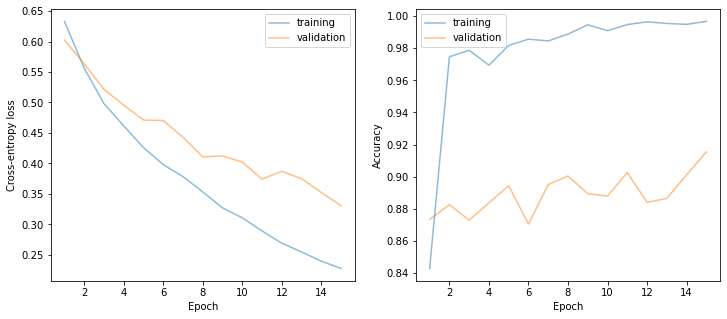

In [19]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].plot(list(range(1, num_epochs + 1)), train_losses, alpha = 0.5, label = "training")
axs[0].plot(list(range(1, num_epochs + 1)), val_losses, alpha = 0.5,label = "validation")
axs[1].plot(list(range(1, num_epochs + 1)), train_accs, alpha = 0.5,label = "training")
axs[1].plot(list(range(1, num_epochs + 1)), val_accs, alpha = 0.5,label = "validation")
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("Cross-entropy loss")
axs[1].set_ylabel("Accuracy")
pass

## Evaluation

In [7]:
test_loader = get_loader(
    test_dataset, batch_size, shuffle=False, num_workers=num_workers
)

In [8]:
model = torch.load('./best_model_deepfakes.pth')

In [14]:
test_loss, test_acc, test_pr_acc, test_tmp_acc = print_validation_info(
        criterion, device, model, test_loader, 0, 0
    )

validation ep. 0: 100%|██████████| 112/112 [00:14<00:00,  7.79it/s]


Validation - Loss: 0.356, Acc: 0.896, Prs: 0.896, Tmp: 0.896


Finally, the accuracy on the test dataset is $0.896$ and the precision of detecting deepfakes is also $0.896$.

## Evaluation the trained model on another dataset

In [15]:
fakedataset_name = "neural_texture"
train_dataset, val_dataset, test_dataset = read_training_dataset(data_dir, max_images_per_video, max_videos, window_size, splits_path, transform, fakedataset_name)

Using training data: 
neural_textures_c40
original_faces_c40


In [16]:
test_loader = get_loader(
    test_dataset, batch_size, shuffle=False, num_workers=num_workers
)

In [17]:
test_loss, test_acc, test_pr_acc, test_tmp_acc = print_validation_info(
        criterion, device, model, test_loader, 0, 0
    )

validation ep. 0: 100%|██████████| 112/112 [00:10<00:00, 10.80it/s]

Validation - Loss: 0.898, Acc: 0.527, Prs: 0.896, Tmp: 0.159


The accuracy is about 0.527. The pristine accuracy is relatively high, 0.896. However, the detection rate (precision) of fake frames is quite 0.159 low even compared to random guessing.